# Analysis of the price of energy in Spain

### Main objective of the analysis

The objective of the analysis is the interpretation of the daily price of energy in Spain and its relationship to a variety of factors.

### Brief description of the data set you chose and a summary of its attributes.

I have built my own dataset which is comprised of variables from different data sources, which I will present indicated between brackets below.
Each observation corresponds to each day between 04 January 2021 and 16 September 2021.

##### Target:
- Price of Energy (€/MWh), (OMIE - Electricity Market operator in Spain)

##### Features:
- Total renewable vs non-renewable energy output (MWh), (REE - Electricity Transport operator of Spain)
- Price of CO2 emission bonds (€/ t CO2), (Sendeco2 - European CO2 Market operator)
- Generation technology that fixes the price. In Spain, there is a price fixation system where the most expensive technology sets the price for the day. (Categorical) (OMIE). In this case, we will see several columns, each corresponding to one technology. As this variable is set every hour, the feature will represent the percentage of the day where a given technology is dominant. For example, if for a given observation HI=0.3333 and TCC=0.666, it will mean that Hydropower has been dominant 33% of the day (=8 hours) whereas thermal energy has been dominant 66% (16 hours).


I will load my dataset now. For this I have made a helper file that handles all the data from different sources, homogeneizes its aspect and produces the dataframe AllSummary: 

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

AllSummary = pd.DataFrame()
%run loadData.ipynb

AllSummary

,Renewable,Non_Renewable,Energy price,CO2 ton price,HI,RE,BG,TCC,TER,MIP,year
2021-01-04,338858.0,443010.0,59.85,33.69,0.416667,0.166667,0.416667,0.000000,0.000000,0.0,2021
2021-01-05,291895.0,436704.0,67.55,32.96,0.416667,0.166667,0.250000,0.083333,0.000000,0.0,2021
2021-01-06,273265.0,407474.0,70.60,33.63,0.666667,0.041667,0.208333,0.083333,0.000000,0.0,2021
2021-01-07,281307.0,486273.0,88.93,34.76,0.333333,0.166667,0.083333,0.041667,0.041667,0.0,2021
2021-01-08,393578.0,416164.0,94.99,34.92,0.750000,0.000000,0.083333,0.000000,0.166667,0.0,2021
...,...,...,...,...,...,...,...,...,...,...,...
2021-09-10,238280.0,475025.0,152.32,61.29,0.375000,0.000000,0.208333,0.375000,0.000000,0.0,2021
2021-09-13,240079.0,468652.0,154.16,61.50,0.500000,0.041667,0.083333,0.375000,0.000000,0.0,2021
2021-09-14,215424.0,528721.0,153.43,59.85,0.458333,0.041667,0.000000,0.458333,0.000000,0.0,2021
2021-09-15,181745.0,574870.0,172.78,59.43,0.375000,0.083333,0.000000,0.250000,0.000000,0.0,2021


### Brief summary of data exploration and actions taken for data cleaning and feature engineering.

I will reproduce the steps followed in the previous assignment, but now with an extended dataframe.

In [19]:
AllSummary.info()
#----CONCLUSIONS:-----
#1) One NaN value appeared in the columns Renovable / Non-renewable because of a missing data in one of the energy generations (Hidroeólica). This feature component is negligible with respect to other energy sources and has been filled as 0.
#2) One of the numerical values (Precio CO2) appears to be an object instead of a float value. This is due to the data containing Spanish decimal separator (,). This was updated in the read_csv command by specifying this decimal separator.

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 182 entries, 2021-01-04 to 2021-09-16
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Renewable      182 non-null    float64
 1   Non_Renewable  182 non-null    float64
 2   Energy price   182 non-null    float64
 3   CO2 ton price  182 non-null    float64
 4   HI             182 non-null    float64
 5   RE             182 non-null    float64
 6   BG             182 non-null    float64
 7   TCC            182 non-null    float64
 8   TER            182 non-null    float64
 9   MIP            182 non-null    float64
 10  year           182 non-null    int64  
dtypes: float64(10), int64(1)
memory usage: 17.1 KB


In [20]:
AllSummary.describe()

#CONCLUSIONS:---
#1) When importing the source file, an extra category '0' is wrongly added (next to MIP) because there is a blank space. This space is removed by putting NaN to that specific element, which will be ignored by the parser.

,Renewable,Non_Renewable,Energy price,CO2 ton price,HI,RE,BG,TCC,TER,MIP,year
count,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.0
mean,342960.587912,379164.071429,78.670989,47.771868,0.534799,0.154991,0.093864,0.148581,0.011218,0.000687,2021.0
std,80803.879579,55251.567013,31.054991,8.576051,0.148241,0.139564,0.085961,0.143962,0.030941,0.005320,0.0
min,181745.000000,257501.000000,7.100000,31.620000,0.208333,0.000000,0.000000,0.000000,0.000000,0.000000,2021.0
25%,279397.000000,337370.000000,55.895000,40.102500,0.416667,0.041667,0.041667,0.041667,0.000000,0.000000,2021.0
50%,336550.500000,373757.000000,79.645000,50.350000,0.541667,0.125000,0.083333,0.083333,0.000000,0.000000,2021.0
75%,393560.750000,415680.750000,94.570000,54.152500,0.656250,0.208333,0.125000,0.239583,0.000000,0.000000,2021.0
max,544944.000000,574870.000000,188.180000,62.850000,0.875000,0.666667,0.458333,0.625000,0.166667,0.041667,2021.0


### Summary of training at least three linear regression models

I have chosen for my project the linear regression, Ridge regression and polynomial regression.

In order to use (as it is required in the assignment) the same data splits for all three methods, I have decided to put all the code in one for loop - that is, in one piece -, at the cost of readability. I will try to put comments so that it is as readable as possible.


Also, for the goal of practice, I will import the whole SciKit module and then access the different submodules directly in the code. 


Average SCORES:
--------------------
SIMPLE LINEAR 0.882
RIDGE 0.884
POLYNOMIAL  -1.168


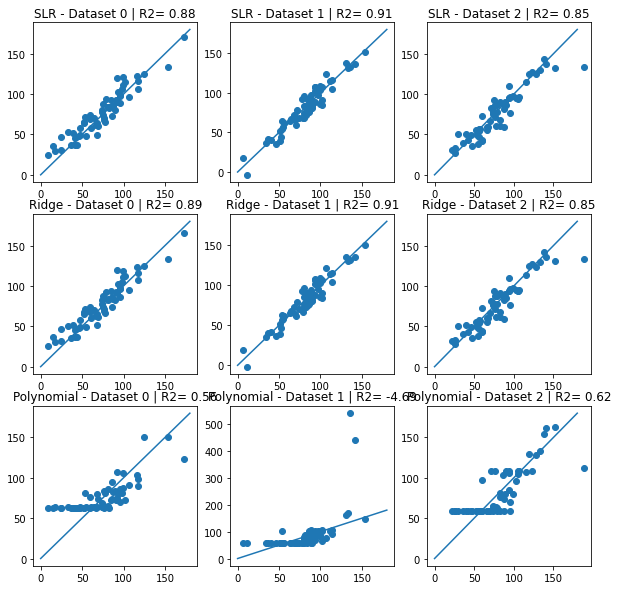

In [39]:
import sklearn as sk
from sklearn import model_selection as skms
from sklearn import metrics as skmetrics
from sklearn import linear_model as sklinear
from sklearn import preprocessing as skpre


#Separating my target variable from the features.
X = AllSummary.drop(['Energy price'], axis= 1)
y = AllSummary['Energy price']
n_splits=3

# Preparing now the common items: we will use a K-Fold of nplits on shuffled values, and scale on all 3 models.
kf = skms.KFold(shuffle=True, n_splits=n_splits)
s = skpre.StandardScaler()

# Now I will prepare the three models that I will be using: each with its particularities.

##For Simple Linear Regression, I only need to instantiate the object.
LR = sklinear.LinearRegression()

##For Ridge Regression, I need to instantiate it also, but with some more paramaters, namely alpha and cv. In this case we're setting cv to None because we are doing the CV manually.
alphas = [0.005, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 80]
Ridge = sklinear.RidgeCV(alphas=alphas, cv=None)

#For polynomial features, I will also need a separate LR object, instantiate a Poly object with degree 20; and isolate the feature I want to concentrate in (CO2 ton price)
X_Poly = AllSummary[['CO2 ton price']]
poly = skpre.PolynomialFeatures(50)
LRPoly = sklinear.LinearRegression()

scores_linear = []
scores_ridge = []
scores_poly = []
params_all = pd.DataFrame()

fig, axs = plt.subplots(nrows=3, ncols=n_splits, figsize=(10,10))
straight=np.linspace(0,180,180)

item=0
for train_index, test_index in kf.split(X):
    X_train, X_test, y_train, y_test = (X.iloc[train_index, :], X.iloc[test_index, :], y[train_index], y[test_index])

    #Standardize X Training Set (Fit + Transform for training values, Transform only for test values). This is valid both for simple LR and Ridge. 
    X_train_s = s.fit_transform(X_train)
    X_test_s = s.transform(X_test)
    
    #SIMPLE LINEAR REGRESSION: Fit, Predict and evaluate accuracy. Then, plot the results.
    LR.fit(X_train_s, y_train)
    y_pred_slr = LR.predict(X_test_s)
    score = skmetrics.r2_score(y_test.values, y_pred_slr)
    scores_linear.append(score)

    axs[0, item].set_title('SLR - Dataset ' + str(item) + " | R2= " +str(round(score,2)))
    axs[0, item].scatter(y_test, y_pred_slr)

  
    #RIDGE REGRESSION: Fit, Predict and evaluate accuracy. Then, plot the results.
    ridgeCV = Ridge.fit(X_train_s, y_train)
    y_pred_ridge = ridgeCV.predict(X=X_test_s)
    score = skmetrics.r2_score(y_test.values, y_pred_ridge)
    scores_ridge.append(score)

    axs[1, item].set_title('Ridge - Dataset ' + str(item) + " | R2= " +str(round(score,2)))
    axs[1, item].scatter(y_test, y_pred_ridge)
    
    #POLYNOMIAL FEATURES: In this case we need to redefine the X, because we only want to concentrate in one of the columns.
    X_train, X_test, y_train, y_test = (X_Poly.iloc[train_index, :], X_Poly.iloc[test_index, :], y[train_index], y[test_index])
    X_trains_s = poly.fit_transform(X_train)
    X_test_s = poly.transform(X_test)
    LRPoly.fit(X_trains_s, y_train)
    y_poly_pred = LRPoly.predict(X_test_s)
    score = skmetrics.r2_score(y_test.values, y_poly_pred)
    scores_poly.append(score)

    axs[2, item].set_title('Polynomial - Dataset ' + str(item) + " | R2= " +str(round(score,2)))
    axs[2, item].scatter(y_test, y_poly_pred)

    item=item+1



for i in range (0,3):
  for j in range (0,3):
    axs[i,j].plot(straight, straight)


print("Average SCORES:\n--------------------")
print("SIMPLE LINEAR", round(np.average(scores_linear),3))
print("RIDGE", round(np.average(scores_ridge),3))
print("POLYNOMIAL ", round(np.average(scores_poly),3))

plt.show()

#So we obtain a pretty interesting score for these analysis. I will now plot each of these:

## Model Recommendation

Here is a capture of the average r2scores that I get in all three models:

**Simple Linear**: 0.882  
**Ridge**: 0.884 with a preferred alpha of 3.0  
**Polynomial**: 0.583  

These results suggest that:
- Both Simple Linear and Ridge Regressions seem to be pretty similar in terms of their predictive power. A plausible reason is the relatively few number of variables involved. [^1] Since there are not so many variables, the possibility of overfitting - and hence the benefit and influence of Ridge is lower.

- Polynomial Regression is comparatively poor. This may be due not only to the this model's natural trend to overfit with its 20 degree. But also, because we are leaving aside many variables with known predictive power such as the amount of non-renewable energy being consumed. 

For the latter reason I would discard the polynomial Regression right away. Of the two models left, it is known that Ridge is more complex than Simple LR because it is taking an extra factor in the minimisation or MRS. However, based on the comparation above, it seems that the benefit does not outweigh the computation costs.

Based on these reasons, I would recommend to use a simple linear regression for this model in particular.

If we repeat the experiment again with a new, shuffled k-fold dataset:

**Simple Linear**: 0.8687  
**Ridge Average**:  0.8725 with a preferred alpha of  3.0  
**Polynomial Linear Average**: 0.54986  

We obtain a pretty similar result, which allows us to confirm the recommendation for Simple LR.

In the following picture I am plotting the y_pred versus the real y.

[^1]: Note that this is a dataset made by myself - the amount of work to gather, homogeneize and merge all this data has been, in fact, been much, much bigger than the work of analyzing it.

In [22]:
  #fig, ax = plt.subplots(n_splits, figsize=(10,10))

#i=1
    
"""     #Plot the results
    ax[i-1].scatter(y_test, y_pred)
    ax[i-1].plot(straight, straight)
    straight=np.linspace(1,180,180)
    i+=1 """

plt.show()

## Summary Key Findings and Insights

As mentioned above my intention was to interpret, rather than predict, the sources of variation of the price of energy in Spain.

### List of main features with its coefficients:

**By amount of energy generated**  
Renewable: -1.02626643  
Non_Renewable: 10.71880792  
**Geopolitical factors**  
CO2 ton price: 11.04619832  
**Technology that controls the market**  
HI: (Hydroelectrical power)  1.99984787  
RE: -3.87695785  
BG: (Pumping Hydroelectrical power)-0.8034641  
TCC: (Gas-only thermal power): 1.58404497  
TER: (Fossil fuel, including gas, but also heavy fuels, thermal power)  2.39543441  
MIP: (Energy Imports from Portugal) -0.04951185  
year:   0.  

### Selection of features with the most explanatory power (both positive and negative)

**CO2 ton price**: ~ 11  
**Non renewable energy generated**: ~ 10.7  
**Days where price is fixed by Fossil fuel, including gas, but also heavy fuels, thermal power:** *(TER)*, ~2.395  
**Days where price is fixed by Gas-only thermal power:** *(TCC)* ~1.584  
**Days where price is fixed by Hydroelectrical power):** *(HI)*  ~1.99985  
**Days where price is fixed by Co-generation, photosolar, thermosolar, windpower, geothermic, wavepower and tidepower** *(RE)* ~-3.88  


### Interpretation

At a glance, there are two factors that stand out:
- The CO2 ton price is an extra cost that all non-renewable energies have to bear and it is negotiated in the markets. Arguably, when this extra cost skyrockets, the technologies that bear it (non-renewable ones) will transfer it to the customers.
- The non-renewable energy shows that the renewable energies are not being enough to cover the demand. This can be due to either unusually high demand (e.g. especially cold winters) or unexpectedly low renewable energy supply (for example low winds yielding low windpower output). As a result, more expensive energies such as gas need to be imported from expensive markets. For the case of Europe, Russia and Algeria are the main suppliers, and the tensions in these markets are known.

From these two main factors, we can conclude that the increse of prices rely, mainly on two factors: first, the fact that much non-renewable energy is being used, which points at high demand rather than low supply [^2]. Second, by a lot of non-renewable being used, the emission rights also become more expensive. Then, the problem may be compounded when these same emission rights suffer market speculation.

If we look further down to the secondary factors, we see that thermal energy technologies tend to push the price higher when they control the market. This is consistent with the fact, shown previously, that these technologies have to pay the burden of being contaminant.
Also unsurprisingly, the energies that pollute the least (such as solar, windpower and seapower), don't have to pay the bonus, are also cheaper in production, and tend to lower the price with a coefficient of -3.9.

The **important surprise** in this analysis is that hydroelectrical energy emerges as a contributor for energy price. 
If anything, hydropower is known for its low production costs. Water is stocked in the dams and then, when convenient, the dam is opened and the water simply drives the turbine.
However, we can see that, when market prices go up, our hydropower companies don't lose the occasion to sell the energy at prices well beyond hundred-fold their real costs. This is the competitive cost that Spanish citizens have to bear when there are only 2 competitors, effectively an oligopoly.

[^2]: Consider that the complementary feature, Renewable energy generated, seems to have comparatively low explanatory power. If the lack of renewable energy availability was a factor, we would probably see a much stronger negative coefficient.

## Possible next steps for data analysis

The analysis seems to behave reasonably well (r2score above 0.85 on its first attempt). However, as I will explain below, there is room for improvement if we reconsider the definition of the variable "Year". Note that this variable is always equal to '2021', bringing no value to the model. In fact, its coefficient is zero, as we would expect, in all three models.

(The explanation for this is that I was planing to analyze data of different years, but the merging of the data only allows to use dates that are present on all sources. As a result, only 9 months of 2021 are present.)

A possible next step would be to refine the feature feature "Time". For example we could define the time origin as 01-Jan-2016 and create a variable equal to the amount of months passed by since then:
- 01-Jan-2016: Months=0
- 03-March-2018: Months=14
- 05-Jan-2022: Months=72

As a result, the new variable would vary across the datasets and potentially bring an explanation as to why the price increases over time.

### Analysis on non-shuffled data

I could also validate this conclusion by deactivating the shuffle mode in item selection:

    kf = skms.KFold(shuffle=True, n_splits=n_splits)

When we set the shuffle mode on the function to False, the r2scores decrease dramatically as shown below:

*SCORES Simple Linear Average:  {0.29639303585157084}*
*SCORES Ridge Average:  0.29505367869446786 with a preferred alpha of  3.0*
*SCORES Polynomial Linear Average:  {-633398570.0740771}*

As the data is ordered by date, a possible interpretation of this is that the time matters. For example, when the shuffle is off we will have datasets defined for each time period.
- First data set. Period covered: 2021Q1 
- Last data set: Period covered: 2021Q4. 

Each period will generate its own model. My assumption is, however, that the models generated for each separate period don't generalize well with each other.
This also suggests that there needs to be an account of the moment where the measurement is done. There may be other external (e.g. geopolitical) variables that we are not taking into account and the Period could be a good way of reflecting them.